# Heritability and Genetic Correlation

https://github.com/bulik/ldsc/wiki/Heritability-and-Genetic-Correlation

In [42]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats import multitest

In [71]:
data_dir = os. getcwd()+'/data/'
# res_dir = os. getcwd()+'/res/'
res_dir = '/Users/feiwang/Documents/Materials/familial_trajectory/'
header = ['ep1', 'ep2', 'rg', 'se','z', 'p', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']

## 1. Process data for LDSC

### if good summary stats can be found from GWAS Catalog:
https://www.ebi.ac.uk/gwas/

In [ ]:
# Choose the summary stats by the effect size. The bigger, the better.
# formula: ((4 * n_cases * n_controls)/(n_cases + n_controls))

ep = 'G6_MS'
# 'T1D_STRICT', 'K11_COELIAC', 'SLE_FG', 'M13_RHEUMA', 'T2D', 'L12_VITILIGO'
# 'G6_MYASTHENIA', 'J10_ASTHMA', 'G6_MS', 'L12_PSORIASIS'

file_in = data_dir+ep+'.txt' # tsv txt
if not os.path.isfile(file_in):
    file_in = data_dir+ep+'.tsv'
if not os.path.isfile(file_in):
    file_in = data_dir+ep+'.csv'
if not os.path.isfile(file_in):
    print('Data cannot be found!')
file_out = data_dir+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
if len(df.columns) == 1:
    df = pd.read_csv(file_in, sep=' ')
if len(df.columns) == 1:
    df = pd.read_csv(file_in)
#     try:
#         df = pd.read_csv(file_in, sep=' ')
#     except pd.errors.ParserError:
#         df = pd.read_csv(file_in)
df = df.rename(columns={
    'rsid': 'snpid', 'SNPID': 'snpid', 'variant_id': 'snpid', 'SNP': 'snpid',
    'effect_allele': 'a1', 'A1': 'a1', 'A1_effect': 'a1',
    'other_allele': 'a2', 'A2': 'a2', 'A2_other': 'a2',
    'p': 'pval', 'P-val': 'pval', 'p_value': 'pval', 'P_EUR': 'pval',
    'OR(A1)': 'or', 'odds_ratio': 'or',
    'standard_error': 'se', 'se_EUR': 'se',
    'beta_EUR': 'beta'
})
print(len(df))
df.head(3)

### if RSID is not in the summary stats:

In [ ]:
Infile="L12_PSORIASIS.tsv"
OutFile="L12_PSORIASIS_TEST.tsv"
HM3ref="HM3Ref"
build="hg37"

In [ ]:
df = pd.read_table(Infile, low_memory=False)
df['hg37'] = 'chr'+df.chromosome.astype(str)+':'+df.base_pair_location.astype(str)
df['A1'] = df.effect_allele.str.upper()
df['A2'] = df.other_allele.str.upper()
Ref = pd.read_table(HM3ref)
ref = Ref.rename(columns={'REF': 'A1', 'ALT': 'A2'})
tmp1 = pd.merge(df, ref, how = 'inner', on = [build, 'A1', 'A2'])
tmp1 = tmp1.drop(['hg36', 'hg37', 'hg38'], axis=1)
ref = Ref.rename(columns={'REF': 'A2', 'ALT': 'A1'})
tmp2 = pd.merge(df, ref, how = 'inner', on = [build, 'A1', 'A2'])
tmp2 = tmp2.drop(['hg36', 'hg37', 'hg38'], axis=1)
tmp = pd.concat([tmp1, tmp2])
tmp.to_csv(OutFile, sep = '\t', index = None)

### if an endpoint has sub dataset for each chromosome:

In [72]:
df = pd.read_csv(data_dir+'/vitiligo/GWAS123chrXcmh.txt', sep='\t')
for i in tqdm.tqdm(range(1, 23)):
    df_ = pd.read_csv(data_dir+'/vitiligo/GWAS123chr'+str(i)+'cmh.txt', sep='\t')
    df_ = df_.rename(columns={'CMH P':'P', 'ORX':'OR'})
    df = pd.concat([df, df_], axis=0)
df['snpid'] = df.SNP.str.lower()
df = df.rename(columns={'A1': 'a1', 'A2': 'a2', 'P': 'p', 'OR': 'or', 'SE': 'se'})
df = df[['a1', 'a2', 'p', 'or', 'se', 'snpid']]
df.to_csv(data_dir+'/autoimmune_gwas_sumstats/L12_VITILIGO.txt', index=None)

100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


### if the format of the summary stats has a problem:
the number of the cols in some rows are larger than the number of the header

In [ ]:
# 'K11_IBD', 'K11_CROHN', 'M13_SJOGREN' finn, 'M13_SYSTSLCE' 格式, 'G6_MS'

ep = 'K11_CROHN'
file_in = data_dir+ep+'.txt'
file_out = data_dir+ep+'.premunge.gz'
matrix = []
with open(file_in) as f:
    for line in f:
        row = line.split(' ')
        if len(row) != 8:
            row = row[:7] + [row[-1]]
        matrix.append(row)
matrix = np.array(matrix)
df = pd.DataFrame(matrix[1:], columns=matrix[0])
df['snpid'] = df['SNP\n'].str[:-1]
df = df.rename(columns={
    'Allele1': 'a1',
    'Allele2': 'a2',
    'P.value': 'pval',
    'Effect': 'beta'
})
df['beta'] = df.beta.astype(float)
df['pval'] = df.pval.astype(float)
print(len(df))
df.head(3)


In [ ]:
# find out which paper using this data by searching the newly found loci in the paper
rsid = 'rs80244186'
a=df[df.snpid == rsid]
print('or: ', round(np.exp(a.iloc[0,-1]), 2))
print('p:  ', a.iloc[0,-2])

### if summary stats can be find from Finngen results:
1. to download data from Finngen + UKBB:
- https://finngen.gitbook.io/finngen-analyst-handbook/finngen-data-specifics/green-library-data-aggregate-data/other-analyses-available/meta-analysis-finngen-ukbb-estbbuntitled
- gsutil cp gs://finngen-production-library-green/finngen_R9/finngen_R9_analysis_data/ukbb_meta/meta/M13_SJOGREN_meta_out.tsv.gz /Users/feiwang/Documents/Materials/familial_trajectory/data

In [196]:
# L12_ALOPECAREATA, N14_IGA_NEPHROPATHY, GEST_DIABETES, G6_OTHDEMYEL, E4_THYROIDITAUTOIM,
# E4_HYTHY_AI_STRICT, D3_ANAEMIA_B12_DEF, CHIRBIL_PRIM, AUTOIMMUNE_HYPERTHYROIDISM, M13_SJOGREN

ep = 'M13_SJOGREN'
file_in = res_dir+'data/'+ep+'_meta_out.tsv.gz'
file_out = res_dir+'processed_stats/'+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
df = df.rename(columns={
    'rsid': 'snpid',
    'REF': 'a1',
    'ALT': 'a2',
    'all_inv_var_meta_p': 'pval',
    'all_inv_var_meta_beta': 'beta'
})
print(len(df))
df.head(3)

31609370


,#CHR,POS,a1,a2,SNP,FINNGEN_beta,FINNGEN_sebeta,FINNGEN_pval,FINNGEN_af_alt,FINNGEN_af_alt_cases,...,UKBB_sebeta,UKBB_pval,UKBB_af_alt,all_meta_N,beta,all_inv_var_meta_sebeta,pval,all_inv_var_meta_mlogp,all_inv_var_het_p,snpid
0,1,11063,T,G,1:11063:T:G,NaN,NaN,NaN,NaN,NaN,...,36.00,0.752,0.000047,1,-11.300,36.000,0.752,0.124,NaN,rs561109771
1,1,13259,G,A,1:13259:G:A,NaN,NaN,NaN,NaN,NaN,...,1.77,0.364,0.000273,1,1.610,1.770,0.364,0.439,NaN,rs562993331
2,1,13668,G,A,1:13668:G:A,0.262,0.349,0.453,0.005851,0.006315,...,NaN,NaN,NaN,1,0.262,0.349,0.453,0.344,NaN,rs2691328


2. to download data from Finngen if the endpoint cannot be found from Finngen + UKBB:
- gsutil cp gs://finngen-production-library-green/finngen_R9/finngen_R9_analysis_data/summary_stats/release/finngen_R9_D3_AIHA_OTHER.gz /Users/feiwang/Documents/Materials

In [ ]:
# D3_AIHA_OTHER, D3_ALLERGPURPURA, D3_ITP, E4_ADDISON, G6_DISSOTH, G6_GUILBAR,
# H7_IRIDOCYC_ANTER, L12_DERMATHERP, M13_MCTD, M13_WEGENER

ep = 'M13_WEGENER'
file_in = data_dir+ep+'.gz'
file_out = data_dir+ep+'.premunge.gz'
df = pd.read_csv(file_in, sep='\t')
df = df.rename(columns={
    'rsids': 'snpid',
    'ref': 'a1',
    'alt': 'a2',
})
print(len(df))
df.head(3)

### save the data as a pre-munge file

In [199]:
# if the data above looks all good, save it as a zipped tsv
df = df[['snpid', 'a2', 'a1', 'pval', 'beta']]
df.to_csv(file_out, sep='\t', compression='gzip', index=None)

## 2. Munge the data and apply LDSC in terminal
- In terminal, run code below:
<code>
    cd Projects/familial_trajectory/ldsc
    source activate ldsc
    ep1=T1D_STRICT
    ep2=K11_IBD
    python munge_sumstats.py \
        --sumstats data/$ep2.premunge.gz \
        --N-cas 2051 \
        --N-con 594747 \
        --out data/$ep2 \
        --merge-alleles w_hm3.snplist \
        --chunksize 500000
    python ldsc.py \
        --rg data/$ep1.sumstats.gz,data/$ep2.sumstats.gz \
        --ref-ld-chr eur_w_ld_chr/ \
        --w-ld-chr eur_w_ld_chr/ \
        --out res/$ep1.$ep2
</code>

## 3. Extract the results from log files and merge the information

In [3]:
def findStats(string):
    stats1 = re.findall(r'data/([\w_\d]+)\.sumstats\.gz', string)
    stats2 = re.findall(r'\s+([-]{0,1}\d\.\d+(e\-\d+){0,1})', string)
    if len(stats2) != 10:
        print(string)
    stats2 = [float("{:.4f}".format(float(i[0]))) for i in stats2]
    stat_dict = dict(zip(header, stats1+stats2))
    return pd.Series(stat_dict)

def readLog(log_file, df):
    with open(log_file) as f:
        log = f.readlines()
    if len(log) != 0:
#         print(log)
        for line in log:
            if re.match(r'^data/', line):
                df = df.append(findStats(line), ignore_index=True)
    return df

In [4]:
eps = ['T1D_STRICT',
 'M13_RHEUMA',
 'M13_SJOGREN',
 'M13_SYSTSLCE',
#  'M13_DERMATOPOLY',
 'M13_WEGENER',
 'D3_ALLERGPURPURA',
 'M13_MCTD',
 'SLE_FG',
#  'I9_RHEUFEV',
 'G6_MS',
 'G6_DISSOTH',
 'AUTOIMMUNE_HYPERTHYROIDISM',
 'E4_THYROIDITAUTOIM',
 'E4_HYTHY_AI_STRICT',
#  'E4_GRAVES_OPHT_STRICT',
 'E4_ADDISON',
 'D3_AIHA_OTHER',
 'D3_ITP',
 'D3_ANAEMIA_B12_DEF',
 'K11_COELIAC',
 'K11_IBD',
 'G6_MYASTHENIA',
 'G6_OTHDEMYEL',
 'G6_MYOMUSCINOTH',
 'G6_GUILBAR',
 'H7_IRIDOCYC_ANTER',
 'CHIRBIL_PRIM',
 'L12_PSORIASIS',
 'L12_VITILIGO',
 'L12_ALOPECAREATA',
#  'L12_PEMPHIGOID',
 'L12_DERMATHERP',
 'N14_IGA_NEPHROPATHY',
 'T2D',
 'GEST_DIABETES',
 'K11_CROHN',
 'J10_ASTHMA']

# eps_dict
# convert eps to interpretable names

In [328]:
eps_dict = {'T1D_STRICT':'Type 1 diabetes',
 'M13_RHEUMA':'Rheumatoid arthritis',
 'M13_SJOGREN':'Sjögren syndrome',
 'M13_SYSTSLCE':'Systemic sclerosis',
 'M13_WEGENER':'Wegener granulomatosis',
 'D3_ALLERGPURPURA':'Allergic purpura',
 'M13_MCTD':'Mixed connective tissue disease',
 'SLE_FG':'Systemic lupus erythematosus',
 'G6_MS':'Multiple Sclerosis',
 'G6_DISSOTH':'Autoimmune acute disseminated demyelination',
 'AUTOIMMUNE_HYPERTHYROIDISM':'Autoimmune hyperthyroidism',
 'E4_THYROIDITAUTOIM':'Autoimmune thyroiditis',
 'E4_HYTHY_AI_STRICT':'Autoimmune hypothyroidism',
            'M13_DERMATOPOLY':'Dermatopolymyositis',
            'E4_GRAVES_OPHT_STRICT':'Graves opthalmopathy',
            'L12_PEMPHIGOID':'Pemphigoid',
            'I9_RHEUFEV':'Rheumatic fever incl heart disease',
 'E4_ADDISON':'Adrenocortical insufficiency',
 'D3_AIHA_OTHER':'Autoimmune haemolytic anaemias',
 'D3_ITP':'Idiopathic thrombocytopenic purpura',
 'D3_ANAEMIA_B12_DEF':'Vitamin B12 deficiency anaemia',
 'K11_COELIAC':'Coeliac disease',
 'K11_IBD':'Inflammatory bowel disease',
 'G6_MYASTHENIA':'Myasthenia gravis',
 'G6_OTHDEMYEL':'Autoimmune demyelinating diseases of the central nervous system',
 'G6_GUILBAR':'Guillain-Barre syndrome',
 'H7_IRIDOCYC_ANTER':'Anterior Iridocyclitis',
 'CHIRBIL_PRIM':'Primary biliary cholangitis',
 'L12_PSORIASIS':'Psoriasis',
 'L12_VITILIGO':'Vitiligo',
 'L12_ALOPECAREATA':'Alopecia areata',
 'L12_DERMATHERP':'Dermatitis herpetiformis',
 'N14_IGA_NEPHROPATHY':'IgA nephropathy',
 'T2D':'Type 2 diabetes',
 'GEST_DIABETES':'Gestational diabetes',
 'K11_CROHN':'Crohn disease',
 'J10_ASTHMA':'Asthma'}

In [316]:
ep1 = 'T1D_STRICT'
stat_df = pd.DataFrame(columns=header, dtype=object)
for ep2 in eps[1:]:
    f_name = res_dir+'ldsc_res/'+ep1+'.'+ep2+'.log'
    if os.path.isfile(f_name):
        stat_df = readLog(f_name, stat_df)
    else:
        print(ep2)
stat_df = stat_df.sort_values(by='h2_obs')
stat_df['fdr_ldsc'], _ = multitest.fdrcorrection(stat_df.p)

M13_SYSTSLCE
G6_MYOMUSCINOTH


## 4. convert h2 from observed scale to liability scale
- https://gist.github.com/nievergeltlab/fb8a20feded72030907a9b4e81d1c6ea
- https://www.sciencedirect.com/science/article/pii/S0002929711000206?via%3Dihub

In [17]:
# Method 1:
import json
with open('/Users/feiwang/Documents/Projects/stats__2021-03-25.json') as f:
    stats = json.load(f)
stat_df['prevalence'] = [stats['stats'][i]['prevalence_all'] for i in stat_df.ep2]

In [317]:
# Method 2:
stats = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='summary')[['Endpoint', 'Prevalence', 'case', 'control']]
stat_df = stat_df.merge(stats.rename(columns={'Endpoint':'ep2', 'Prevalence':'prevalence'}), 'left', on='ep2') 
stat_df['prevalence'] = stat_df['prevalence']*0.01

h2_liab <- h2 * K^2 * ( 1 - K)^2 / P / (1-P) / zv^2

var_h2_liab <- ( seh2 * K^2 * ( 1 - K)^2 / P / (1-P) / zv^2) ^2

In [318]:
stat_df['z_pdf'] = norm.pdf(norm.ppf(1-stat_df['prevalence']))
stat_df['proportion'] = stat_df.case / stat_df.control
stat_df['h2_lia'] = stat_df.h2_obs*(stat_df.prevalence**2)*(1-stat_df.prevalence)**2/stat_df.proportion/(1-stat_df.proportion)/(stat_df.z_pdf**2)
stat_df['se_lia'] = stat_df.h2_obs_se*(stat_df.prevalence**2)*(1-stat_df.prevalence)**2/stat_df.proportion/(1-stat_df.proportion)/(stat_df.z_pdf**2)

In [92]:
from scipy.stats import chi2
chi2.cdf(1-(0.021359**2)/(0.046990**2), 1)

0.6269230284025792

In [319]:
stat_df['rg_025'] = stat_df.rg - 1.96*stat_df.se
stat_df['rg_975'] = stat_df.rg + 1.96*stat_df.se

## 5. Visualize the final results

In [323]:
def plot_odds_ratio(df, outcome):
    """
    :param results: a DataFrame of summary statistics
    :param eps: a list of diseases
    :param outcome: a string which indicates the outcome disease name
    :param group_delta: a float which indicates the distance between father's OR and mother's OR given the same disease
    :param bar_cap: a float which indicates the length of error bar cap
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    plt.figure(figsize=(15, 5))
    plt.box(False)
    plt.grid()
    eps_sig = []
    for i, row in df.iterrows():
        alpha = 1 if row.pval <= 0.05 / len(df) else 0.08
        if alpha == 1:
            eps_sig.append(row.endpoint)
        plt.plot((i, i), (row.hr_025, row.hr_975), color='green', alpha=alpha)
        plt.plot(i, (row.hr_025+row.hr_975)/2, 's', color='green', alpha=alpha)

    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    plt.ylabel('Odds ratio', size=12)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
    plt.grid()
    plt.title(outcome, size=20)
    plt.show()
    return eps_sig

In [334]:
registry_res

,Unnamed: 0,endpoint,note,who,se,pval,hr_025,hr_975,n_valid_group,n_cases,n_valid_pair00,n_valid_pair01,n_valid_pair10,n_valid_pair11
0,0,T1D_STRICT,all,parent,0.103712,1.318019e-63,4.678044,7.024647,374,421,5323,149,1552,272
1,1,M13_RHEUMA,all,parent,0.039939,8.762632e-25,1.394108,1.630380,2316,3074,17942,2065,5660,1009
2,2,M13_SJOGREN,all,parent,0.093005,1.464448e-03,1.120328,1.613161,518,551,5190,381,1687,170
3,3,M13_SYSTSLCE,all,parent,0.204458,1.126646e-01,0.926452,2.064875,110,112,1177,77,383,35
4,4,M13_DERMATOPOLY,all,parent,0.236416,4.485805e-01,0.752605,1.901266,87,88,867,63,285,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,L12_DERMATHERP,girl,mother,0.390677,7.588419e-01,0.524257,2.424562,79,33,324,24,107,9
69,69,M13_MCTD,girl,mother,0.181713,3.906730e-04,1.334102,2.719801,285,129,1079,79,336,50
70,70,M13_RHEUMA,girl,mother,0.075197,1.563689e-10,1.396269,1.874927,1634,825,5082,540,1589,285
71,71,T1D_STRICT,girl,mother,0.253171,2.536334e-07,2.245414,6.057529,149,64,703,29,209,35


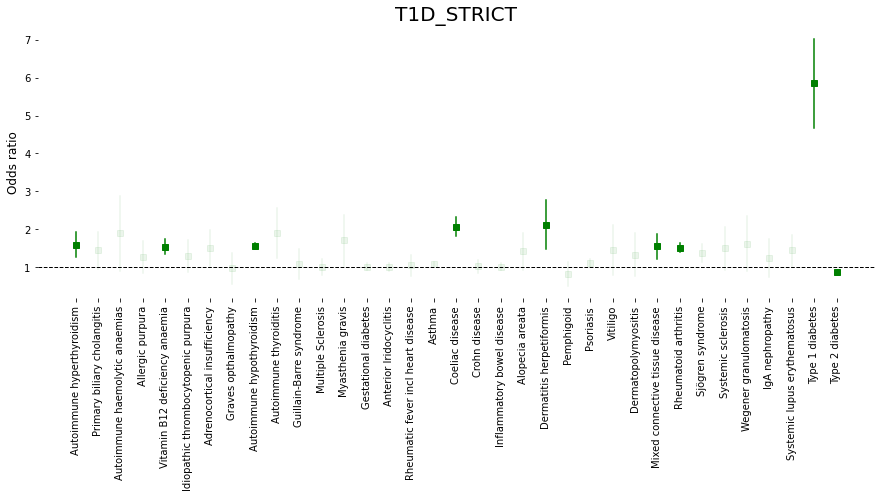

In [339]:
# registry_res = pd.read_excel(res_dir+'summary_of_ADs.xlsx', sheet_name='registry_res')
eps_sig = plot_odds_ratio(registry_res[(registry_res.who == 'parent')&(~registry_res.endpoint.isin(['G6_OTHDEMYEL', 'G6_DISSOTH']))], 'T1D_STRICT')

In [248]:
def process_crossed_data(dataset, note):
    """
    :param data: a DataFrame of summary statistics
    :param note: 'boy', 'girl'
    :return: a DataFrame of processed summary statistics
    """
    df1 = dataset[(dataset.note == note) & (dataset.who == 'father')][['endpoint',"pval", "hr_025", "hr_975", "se"]]
    df1 = df1.rename(columns={"pval": 'p_fa', "hr_025": 'lower_fa', "hr_975": 'upper_fa', "se": 'se_fa'})
    df2 = dataset[(dataset.note == note) & (dataset.who == 'mother')][['endpoint',"pval", "hr_025", "hr_975", "se"]]
    df2 = df2.rename(columns={"pval": 'p_mo', "hr_025": 'lower_mo', "hr_975": 'upper_mo', "se": 'se_mo'})
    df1 = df1.merge(df2, 'outer', on='endpoint')

    df1['hr_fa'] = (df1.lower_fa + df1.upper_fa) / 2
    df1['hr_mo'] = (df1.lower_mo + df1.upper_mo) / 2
    df1['hr_test'] = (df1.hr_fa - df1.hr_mo) / np.sqrt(df1.se_fa ** 2 + df1.se_mo ** 2)  # t-test
    df1['hr_p'] = 2 * scipy.stats.norm.cdf(-np.abs(df1.hr_test))
    df1['hr_significant'] = [True if i < 0.05 / len(df1) else False for i in df1.hr_p]

    return df1

In [330]:
from matplotlib.ticker import ScalarFormatter
def plot_crossed_odds_ratio(data, note, color, outcome='T1D_STRICT'):
    """
    :param data: a DataFrame of summary statistics
    :param note_tuple: a tuple which indicates the two group names
    :param outcome: a string which indicates the outcome disease name
    :return: a odds ratio plot of the diseases by groups
    """
    dataset = process_crossed_data(data, note)
    plt.figure(figsize=(7, 7))
    plt.box(False)

    for _, row in dataset.iterrows():
        x, y = row.hr_fa, row.hr_mo
        if row.hr_significant:
            alpha = 1
            plt.annotate(eps_dict[row.endpoint], (x*1.05, y*1.05))
        else:
            alpha = .1
        plt.plot(x, y, 's', color=color, alpha=alpha)
        plt.plot((row.lower_fa, row.upper_fa), (y, y), color=color, alpha=alpha)
        plt.plot((x, x), (row.lower_mo, row.upper_mo), color=color, alpha=alpha)

    plt.title(note, size=16)
    plt.xlabel('Father', size=12)
    plt.ylabel('Mother', size=12)
    plt.xscale('log')
    plt.yscale('log')
    ticks = [.5, 1, 3, 12]
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.plot([ticks[0], ticks[-1]], [ticks[0], ticks[-1]], color='grey', linestyle='--', linewidth=1)
    ax = plt.gca()
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    plt.grid()
    plt.show()

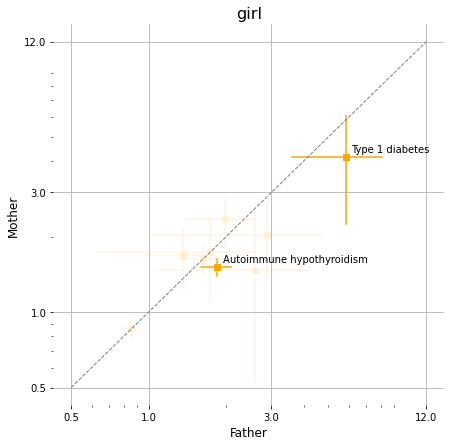

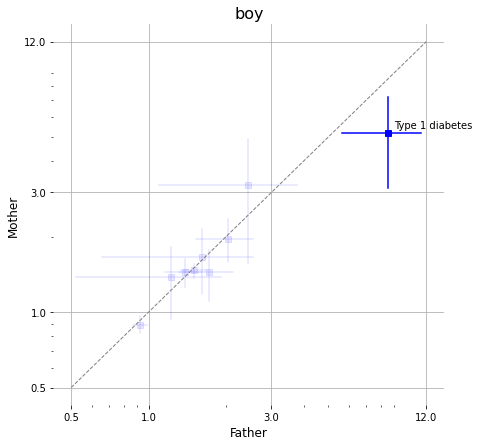

In [340]:
plot_crossed_odds_ratio(registry_res[~registry_res.endpoint.isin(['G6_OTHDEMYEL', 'G6_DISSOTH'])], 'girl', 'orange')
plot_crossed_odds_ratio(registry_res[~registry_res.endpoint.isin(['G6_OTHDEMYEL', 'G6_DISSOTH'])], 'boy', 'blue')

In [332]:
def plot_comparisons(df, outcome):
    """
    :param results: a DataFrame of summary statistics
    :param eps: a list of diseases
    :param outcome: a string which indicates the outcome disease name
    :param group_delta: a float which indicates the distance between father's OR and mother's OR given the same disease
    :param bar_cap: a float which indicates the length of error bar cap
    :return: a odds ratio plot of all the diseases in the list
    """
    df = df.sort_values(by='endpoint')
    df.index = range(len(df))
    fig, (ax2,ax1) = plt.subplots(nrows=2, sharex=True, figsize=(15, 5), subplot_kw=dict(frameon=False)) # frameon=False removes frames
    plt.subplots_adjust(hspace=.5)
    for i, row in df.iterrows():
        alpha_rg = 1 if row.p_rg <= 0.05 / len(df) else 0.08
        alpha_hr = 1 if row.p_hr <= 0.05 / len(df) else 0.08
        ax1.plot((i, i), (row.rg_025, row.rg_975), color='tomato', alpha=alpha_rg)
        ax1.plot(i, (row.rg_025+row.rg_975)/2, 's', color='tomato', alpha=alpha_rg)
        ax2.plot((i, i), (row.hr_025, row.hr_975), color='green', alpha=alpha_hr)
        ax2.plot(i, (row.hr_025+row.hr_975)/2, 's', color='green', alpha=alpha_hr)
    ax1.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1)
    plt.xticks(range(len(df)), [eps_dict[i] for i in df.endpoint.tolist()], rotation=90)
    ax1.set_ylabel('Genetic correlation', size=12)
    ax2.set_ylabel('Registry-based odds ratio', size=12)
    plt.show()


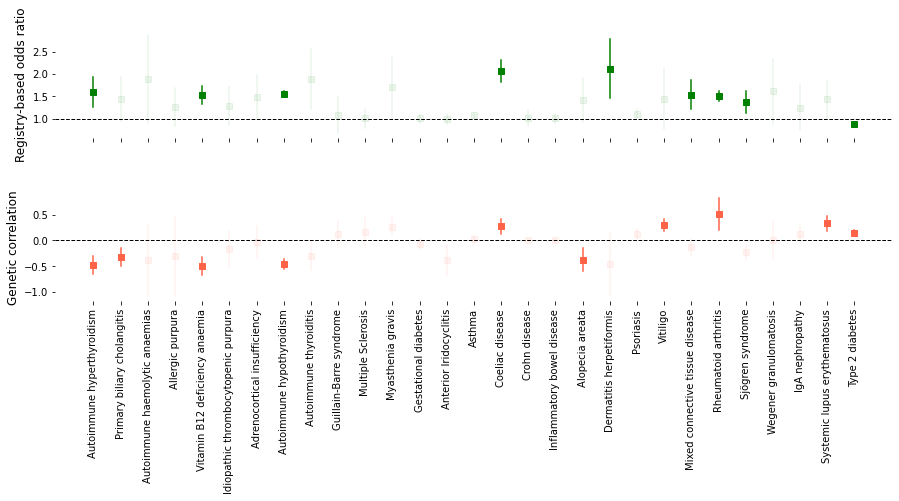

In [341]:
res = stat_df[['ep2', 'rg_025', 'rg_975', 'p']].rename(columns={'ep2': 'endpoint', 'p': 'p_rg'})
res = res[~res.endpoint.isin(['G6_OTHDEMYEL', 'G6_DISSOTH'])]
res = res.merge(registry_res[registry_res.who == 'parent'][['endpoint', 'pval', 'hr_025', 'hr_975']].rename(columns={'pval':'p_hr'}), 'left', on='endpoint')
plot_comparisons(res, 'T1D_STRICT')

In [342]:
res

,endpoint,rg_025,rg_975,p_rg,p_hr,hr_025,hr_975
0,D3_ALLERGPURPURA,-1.071756,0.480956,0.4559,3.215633e-01,0.841004,1.694749
1,D3_AIHA_OTHER,-1.086516,0.313316,0.2789,1.040725e-01,0.906008,2.880248
2,L12_DERMATHERP,-1.066520,0.146720,0.1373,1.790373e-05,1.462135,2.770815
3,D3_ITP,-0.513072,0.175672,0.3370,2.558398e-01,0.868154,1.701432
4,M13_WEGENER,-0.342652,0.348052,0.9877,1.410319e-01,0.886307,2.336776
5,E4_ADDISON,-0.331356,0.270756,0.8439,3.994333e-02,1.016159,1.977535
6,L12_ALOPECAREATA,-0.590936,-0.153464,0.0008,1.210855e-01,0.927486,1.905818
7,E4_THYROIDITAUTOIM,-0.572420,-0.045180,0.0216,2.181956e-03,1.228194,2.547612
8,N14_IGA_NEPHROPATHY,-0.055644,0.302644,0.1766,5.493398e-01,0.742734,1.749033
9,G6_GUILBAR,-0.123656,0.370656,0.3276,1.000000e+00,0.675139,1.481175
